In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Homework1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2023-2024] AN2DL/Homework1


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions

# !pip install tensorflow
# from tensorflow.keras.applications.resnet_v2 import ResNetV2
# from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
# from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input






import cv2
import collections
import json
from PIL import Image
import pickle
# !pip install keras-cv
# import keras_cv


2.14.0


### Load the data

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
print("Arrays in the file:", data.files)
array_keys = data.files


num_images_to_display = 5
label_str = array_keys[1]
data_str= array_keys[0]
labels = data[label_str]
data_images_raw = data[data_str]
data_images = (data_images_raw / 255).astype(np.float32) # Normalize data to the range [0, 1]



num_images_to_display = 10
plt.figure(figsize=(20, 20))  # Set the overall figure size


for i in range(num_images_to_display):
    idx = np.random.randint(0,5200)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(data_images[idx,:,:,:])  # Afficher l'image
    plt.title(f"Label: {labels[idx]}")  # Set the title with the label
    plt.axis('off')  # Pour désactiver les axes
plt.tight_layout()
plt.show()

Arrays in the file: ['data', 'labels']


### Removing outliers

In [ ]:

# Inspect the data, look for shreks and comic books


model_mobilenet = MobileNetV2(weights = 'imagenet')



list_leaf = ['head_cabbage', 'artichoke','cardoon','custard_apple','fig','vine_snake','cauliflower','bell_pepper','three-toed_sloth','hen-of-the-woods']
suspect_outliers_list = []
suspect_outliers_index = []
real_outliers = []
real_outliers_index = []

for i in range(0,5200):
  res = cv2.resize(data_images_raw[i,:,:,:], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  data_mobilenet = preprocess_input(res)
  data_mobilenet = np.expand_dims(data_mobilenet,axis = -4)
  mobilenet_predictions = model_mobilenet.predict(data_mobilenet)
  first_tuple = decode_predictions(mobilenet_predictions)[0][0]
  if first_tuple[1] =='comic_book': # image of the trololo picture
    real_outliers.append(first_tuple[1])
    real_outliers_index.append(i)
    continue
  elif first_tuple[1] =='rock_beauty': # image of the shrek picture
    real_outliers.append(first_tuple[1])
    real_outliers_index.append(i)
    continue
  elif first_tuple[1] not in list_leaf:
    suspect_outliers_list.append(first_tuple[1])
    suspect_outliers_index.append(i)

# Save lists of outliers
# lists_to_write = ['real_outliers', 'real_outliers_index','suspect_outliers_list','suspect_outliers_index']
# data = {listname: globals()[listname] for listname in lists_to_write}

# with open('lists_outliers', 'w') as file:
#     json.dump(data, file, indent=2)

# Load the saved list

# with open('lists_outliers', 'r') as file:
#     data_json = json.load(file)

# print(data_json)


for i in suspect_outliers_index[0:5]:
    plt.imshow(data_images[i,:,:,:])  # Afficher l'image
    plt.title(f"Label: {[i]}")  # Set the title with the label
    plt.show()
    key = cv2.waitKey(1000)#pauses for 3 seconds before fetching next image

plt.imshow(data_images[338,:,:,:])  # Afficher l'image
plt.show()



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step


IndexError: ignored

### Removing duplicates

In [ ]:



mean_list = []

for i in range(0,4995):
  mean1 = np.mean(data_images[i,:,:,0])
  mean2 = np.mean(data_images[i,:,:,1])
  mean3 = np.mean(data_images[i,:,:,2])
  mean = mean1*mean2*mean3
  mean_list.append(mean)

zero_indices = [index for index, value in enumerate(mean_list) if value == 0]
print("Indices of zero:", zero_indices)

#Create a dictionary to store indexes of elements
index_dict = {}
duplicates = []

# Iterate through the list to find duplicates and their indexes
for idx, value in enumerate(mean_list):
    if value in index_dict:
        duplicates.append(value)
        index_dict[value].append(idx)
    else:
        index_dict[value] = [idx]

# Filter duplicates and their indexes
duplicate_indexes = {value: indexes for value, indexes in index_dict.items() if len(indexes) > 1}

print("Duplicates:", list(set(duplicates)))  # Print unique duplicates
print("Duplicate Indexes:", duplicate_indexes)  # Print indexes of duplicates

index_to_delete = []
for value, indexes in duplicate_indexes.items():
    indexes.sort()  # Sort indexes
    index_value = indexes[0]
    for i in range(1,len(indexes)):
        diff = data_images[index_value,:,:,:] - data_images[indexes[i],:,:,:]
        index_to_delete.append(indexes[i])
        if np.mean(diff) != 0:  # Check difference between indexes
            print(f"Error: images are not same")
            print(index_value)
            print(indexes[i])

index_to_delete = np.sort(index_to_delete)
print(index_to_delete[0:5])

# Suppress duplicates

for i in reversed(index_to_delete) :
  # plt.imshow(data_images[i,:,:,:])  # Afficher l'image
  # plt.show()
  data_images = np.delete(data_images,i,axis = 0)
  labels = np.delete(labels,i,axis = 0)

# new_cleaned_dataset = {"cleaned_labels" : labels, "cleaned_images" :data_images }

# with open('new_cleaned_data.pkl', 'wb') as fp:
#     pickle.dump(new_cleaned_dataset, fp)



NameError: ignored

### Load Clean Data

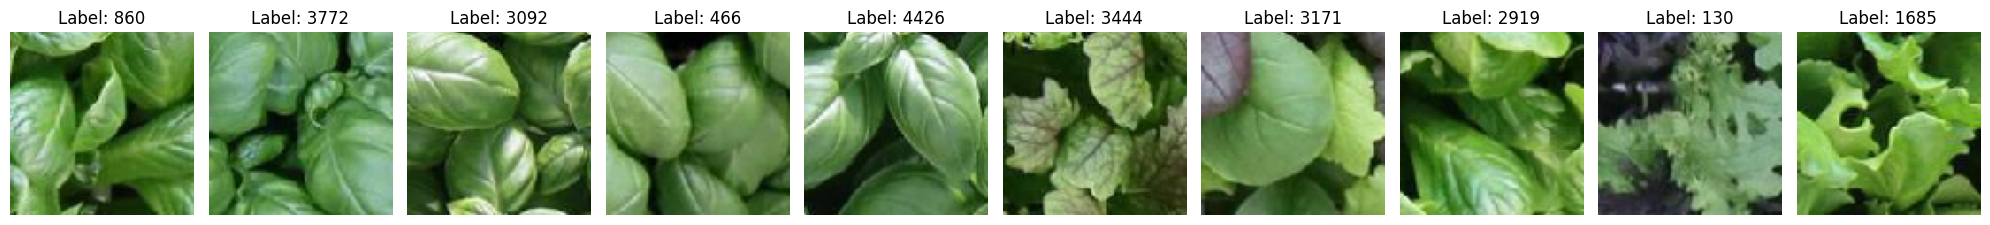

Proportion of healthy :  0.6306548233835985
Proportion of unhealthy :  0.3693451766164016


In [ ]:
with open('new_cleaned_data.pkl', 'rb') as fp:
    import_cleaned_data = pickle.load(fp)


data_images = import_cleaned_data["cleaned_images"]
labels = import_cleaned_data["cleaned_labels"]



num_images_to_display = 10
plt.figure(figsize=(20, 20))  # Set the overall figure size


for i in range(num_images_to_display):
    idx = np.random.randint(0,4995)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(data_images[idx,:,:,:])  # Afficher l'image
    plt.title(f"Label: {idx}")  # Set the title with the label
    plt.axis('off')  # Pour désactiver les axes
plt.tight_layout()
plt.show()


healthy = []
unhealthy = []


for i in range(np.size(data_images,0)):
  if labels[i] == 'healthy':
    healthy.append(data_images[i,:,:,:])
  else :
    unhealthy.append(data_images[i,:,:,:])

print("Proportion of healthy : ",np.size(healthy,0)/(np.size(healthy,0) + np.size(unhealthy,0)))
print("Proportion of unhealthy : ",np.size(unhealthy,0)/(np.size(healthy,0) + np.size(unhealthy,0)))

X = np.concatenate([healthy, unhealthy], axis=0)

# 0 for healthy and 1 for unhealthy
y = np.concatenate([np.zeros(len(healthy)), np.ones(len(unhealthy))], axis=0)
y = tfk.utils.to_categorical(y,len(np.unique(y))) # Convert labels to categorical format using one-hot encoding


### Data Augmentation

In [ ]:
# CutMix Augmentation

def rand_bbox(size, lamb):
    """ Generate random bounding box
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """

    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)

    return image_batch_updated, label



def mixup(image, label, prob=1.0, alpha=0.2):
    batch_size = tf.shape(image)[0]
    image_mix = image
    label_mix = []

    for i in range(batch_size):
        # Randomly select an image and label to mix with
        index = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_to_mix = image[index]
        label_to_mix = label[index]

        # Generate parameters for MixUp
        lam = tf.random.uniform([], 0, 1)

        # Mix the images
        mixed_image = lam * image[i] + (1 - lam) * image_to_mix
        image_mix[i] = mixed_image

        # Mix the labels
        mixed_label = lam * label[i] + (1 - lam) * label_to_mix
        label_mix.append(mixed_label)

    label_mix = tf.stack(label_mix)

    return image_mix, label_mix

flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.25),
])

translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])
rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.15),
])

def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def color_jitter(image_in, jitter_range=0.2):
    # Convert image to array
    image = image_in

    # Define random values for jittering
    jitter_values = {
        'red': np.random.uniform(-jitter_range, jitter_range),
        'green': np.random.uniform(-jitter_range, jitter_range),
        'blue': np.random.uniform(-jitter_range, jitter_range)
    }

    # Apply jittering to each channel (RGB)
    image[:, :, 0] *= (1.0 + jitter_values['red'])
    image[:, :, 1] *= (1.0 + jitter_values['green'])
    image[:, :, 2] *= (1.0 + jitter_values['blue'])

    image = np.clip(image, 0.0, 1.0)

    # Convert array back to image
    return image
def color_jitter_batch(images, jitter_range=0.2):
    # Create a copy of the input images to avoid modifying the originals
    images_copy = np.copy(images)

    # Define random jitter values for each channel
    jitter_values = {
        'red': np.random.uniform(-jitter_range, jitter_range, size=images.shape[0]),
        'green': np.random.uniform(-jitter_range, jitter_range, size=images.shape[0]),
        'blue': np.random.uniform(-jitter_range, jitter_range, size=images.shape[0])
    }

    # Apply jittering to each channel for all images
    images_copy[:, :, :, 0] *= (1.0 + jitter_values['red'][:, np.newaxis, np.newaxis])
    images_copy[:, :, :, 1] *= (1.0 + jitter_values['green'][:, np.newaxis, np.newaxis])
    images_copy[:, :, :, 2] *= (1.0 + jitter_values['blue'][:, np.newaxis, np.newaxis])

    # Clip pixel values to stay within [0, 1]
    images_copy = np.clip(images_copy, 0.0, 1.0)

    return images_copy

def cutout_batch(images, mask_size=16):
    # Create a copy of the input images to avoid modifying the originals
    images_copy = np.copy(images)

    # Get image dimensions
    num_images, img_height, img_width, num_channels = images.shape

    # Generate random coordinates for cutout masks
    mask_x = np.random.randint(0, img_width - mask_size, size=num_images)
    mask_y = np.random.randint(0, img_height - mask_size, size=num_images)

    for i in range(num_images):
        # Apply cutout mask to each image
        images_copy[i, mask_y[i]:mask_y[i] + mask_size, mask_x[i]:mask_x[i] + mask_size, :] = 0.0

    return images_copy


### Training and Validation sets

In [ ]:
# Creation of training and validation set
test_size = int(np.round(X.shape[0]/3))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed,stratify = np.argmax(y,axis=1))

# Apply data Augmentation
X_augmented,y_augmented = mixup(np.array((X_train[0:900])),y_train[0:900],prob=1.0, alpha=0.2) # Apply mixup augmentation on 900 images
X_train = np.concatenate((X_train,X_augmented),axis=0)
y_train = np.concatenate((y_train,y_augmented),axis=0)
X_augmented,y_augmented = cutout_batch(color_jitter_batch(X_train[900:1400,:,:,:],0.8),25),y_train[900:1400]# Apply cutout and color jittering augmentation on 500 images
X_train = np.concatenate((X_train,X_augmented),axis=0)
y_train = np.concatenate((y_train,y_augmented),axis=0)


# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)


tf.Tensor(
[[1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.75201464 0.24798536]
 [1.         0.        ]], shape=(7, 2), dtype=float32)


In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Input Shape: (96, 96, 3)
Output Shape: 2


### Transfer Learning with EfficientNet

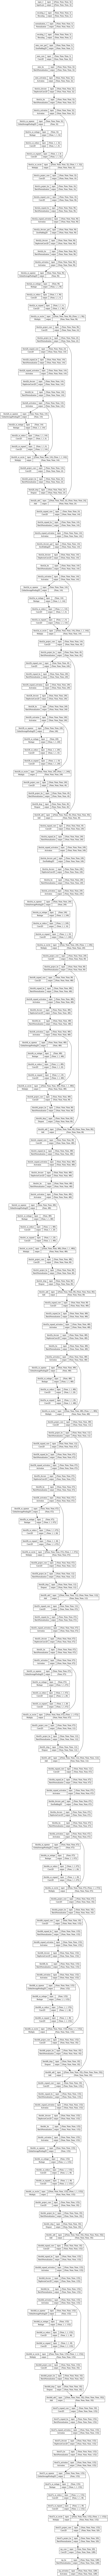

In [ ]:
efficient = EfficientNetB0(include_top=False, weights='imagenet')

tfk.utils.plot_model(efficient, show_shapes=True)

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
efficient.trainable = False
l2_lambda = 2e-5
dropout_rate = 1/5

def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("vertical"),
        tfkl.RandomZoom(0.25),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.15)
    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)
    x = efficient(preprocessing) # Size : 2048

    x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Dropout(dropout_rate, name="top_dropout")(x)

    outputs = tfkl.Dense(2, activation="softmax", name="pred")(x)


    # x = tfkl.Dense(units=640, kernel_initializer=tfk.initializers.HeNormal(seed=seed), name='HiddenDense1', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
    # x = tfkl.BatchNormalization()(x)
    # hidden_activation = tfkl.Activation('relu', name='HiddenActivation1')(x)
    # dropout = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

    # x = tfkl.Dense(units=210, kernel_initializer=tfk.initializers.HeNormal(seed=seed), name='HiddenDense2', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(dropout)
    # x = tfkl.BatchNormalization()(x)
    # hidden_activation = tfkl.Activation('relu', name='HiddenActivation2')(x)
    # dropout = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

    # outputs = tfkl.Dense(2, activation='softmax')(dropout)

    model = tfk.Model(inputs=input_layer, outputs=outputs, name='EfficientNet')


    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate = 1e-3), metrics=['accuracy'])

    # Return the model
    return model


model = build_model()
model.summary()


Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                      

In [ ]:
for i, layer in enumerate(efficient.layers):
   print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Transfer learning the model
tl_history = model.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 70,
    epochs = 250,
    validation_data = ((X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history

Epoch 1/200
67/67 [==============================] - 28s 220ms/step - loss: 0.7914 - accuracy: 0.6259 - val_loss: 0.5238 - val_accuracy: 0.7379
Epoch 2/200
67/67 [==============================] - 8s 115ms/step - loss: 0.6504 - accuracy: 0.6881 - val_loss: 0.4874 - val_accuracy: 0.7757
Epoch 3/200
67/67 [==============================] - 11s 167ms/step - loss: 0.6030 - accuracy: 0.7193 - val_loss: 0.4599 - val_accuracy: 0.7776
Epoch 4/200
67/67 [==============================] - 14s 213ms/step - loss: 0.5801 - accuracy: 0.7242 - val_loss: 0.4379 - val_accuracy: 0.8011
Epoch 5/200
67/67 [==============================] - 11s 171ms/step - loss: 0.5577 - accuracy: 0.7376 - val_loss: 0.4339 - val_accuracy: 0.7918
Epoch 6/200
67/67 [==============================] - 10s 152ms/step - loss: 0.5435 - accuracy: 0.7424 - val_loss: 0.4339 - val_accuracy: 0.7949
Epoch 7/200
67/67 [==============================] - 10s 147ms/step - loss: 0.5563 - accuracy: 0.7342 - val_loss: 0.4478 - val_accuracy: 

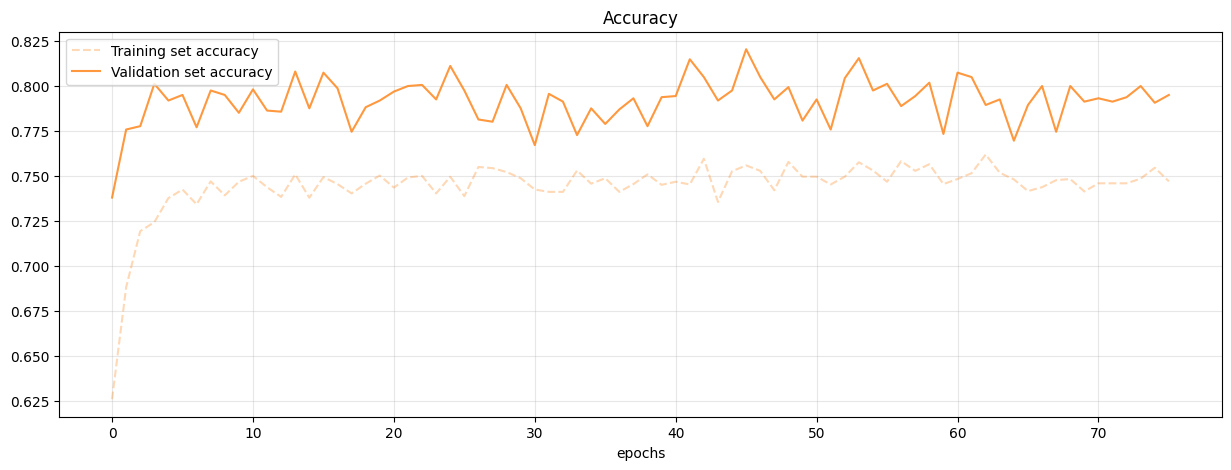

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--',label='Training set loss')
plt.plot(tl_history['val_loss'], label='Validation set loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--',label='Training set accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation set accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Fine Tuning

In [ ]:
def unfreeze_model(model):
    efficient.trainable = True
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in efficient.layers[:207]:
      layer.trainable = False
    for layer in efficient.layers:
      if isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = False


    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

for i, layer in enumerate(efficient.layers):
   print(i, layer.name, layer.trainable)
model.summary()



ft_history = model.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 70,
    epochs = 250,
    validation_data = ((X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=45, restore_best_weights=True)]
).history

0 input_4 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

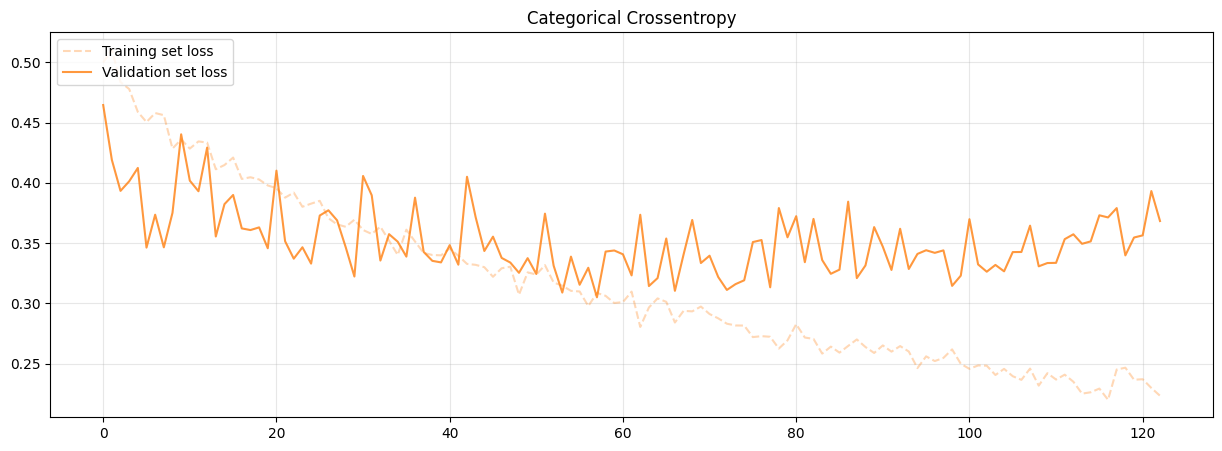

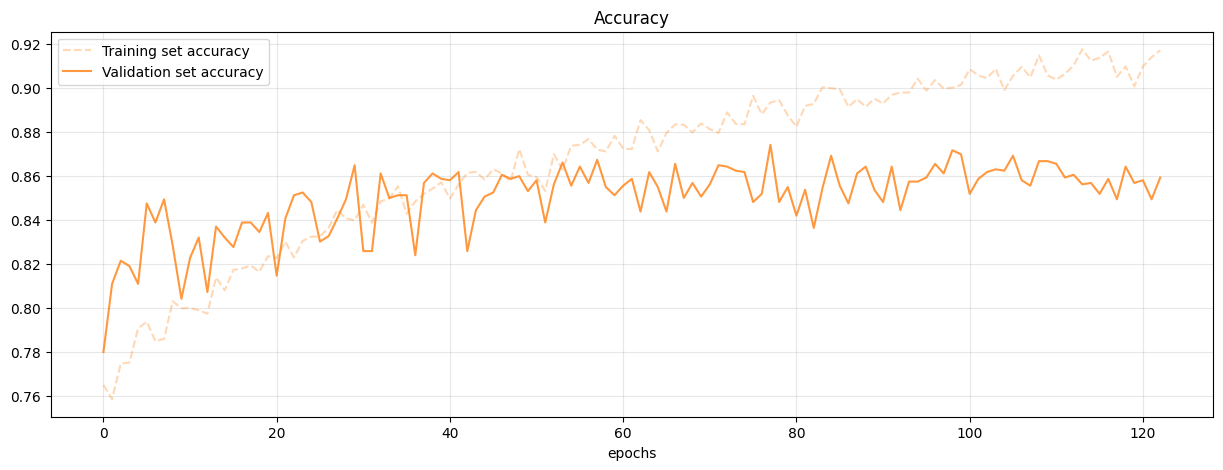

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--',label='Training set loss')
plt.plot(ft_history['val_loss'], label='Validation set loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--',label='Training set accuracy')
plt.plot(ft_history['val_accuracy'], label='Validation set accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
def unfreeze_model(model):
    efficient.trainable = True
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in efficient.layers[:177]:
      layer.trainable = False
    for layer in efficient.layers[207:]:
      layer.trainable = False
    for layer in efficient.layers[:]:
      if isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = False


    optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

for i, layer in enumerate(efficient.layers):
   print(i, layer.name, layer.trainable)
model.summary()


ft_history = model.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 70,
    epochs = 200,
    validation_data = ((X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history



0 input_4 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

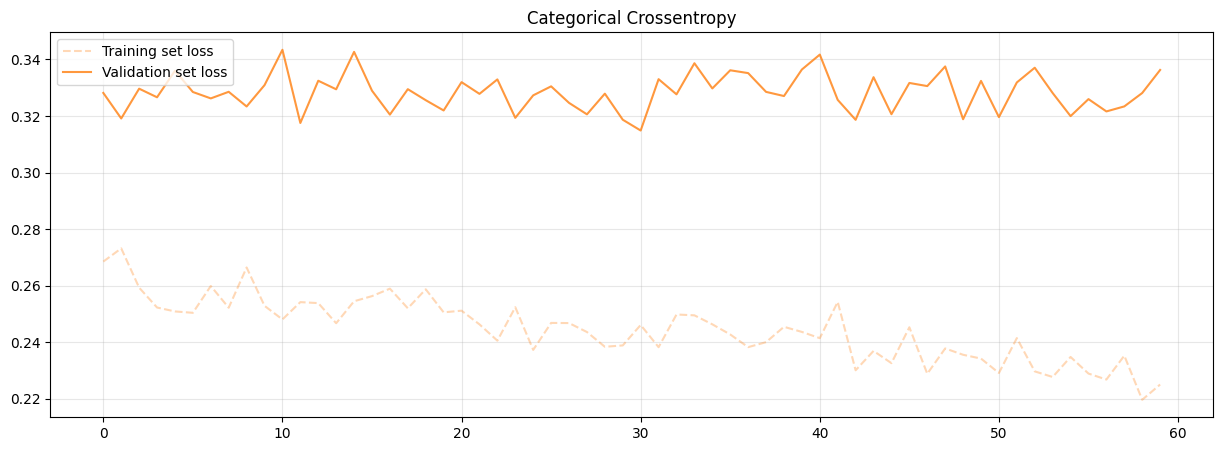

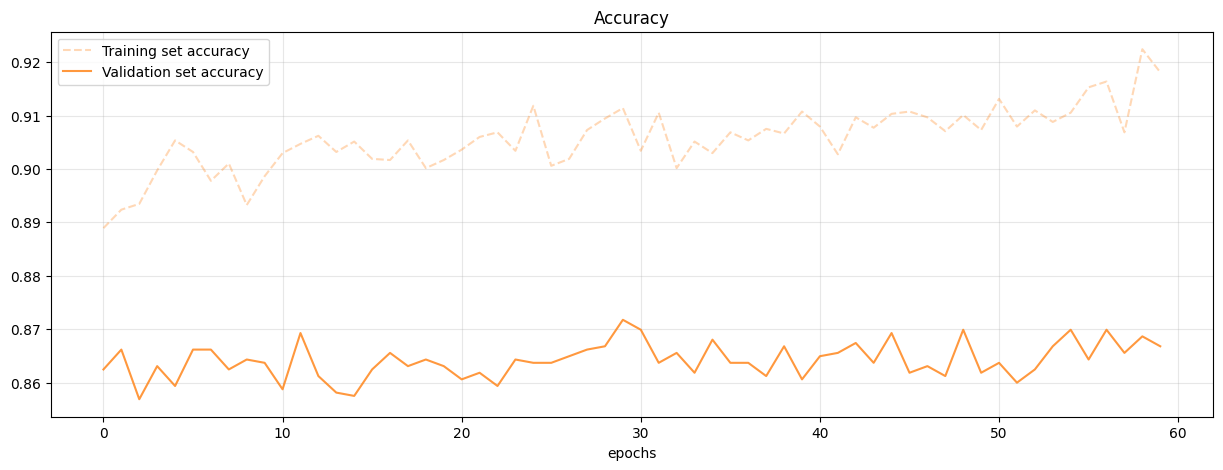

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--',label='Training set loss')
plt.plot(ft_history['val_loss'], label='Validation set loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--',label='Training set accuracy')
plt.plot(ft_history['val_accuracy'], label='Validation set accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# test_accuracy = model.evaluate(X_val*255,y_val,verbose=0)[-1]
# print('Validation set accuracy %.4f' % test_accuracy)

# model.save('EfficientNet_Fine_Tuning_4')

Validation set accuracy 0.8589


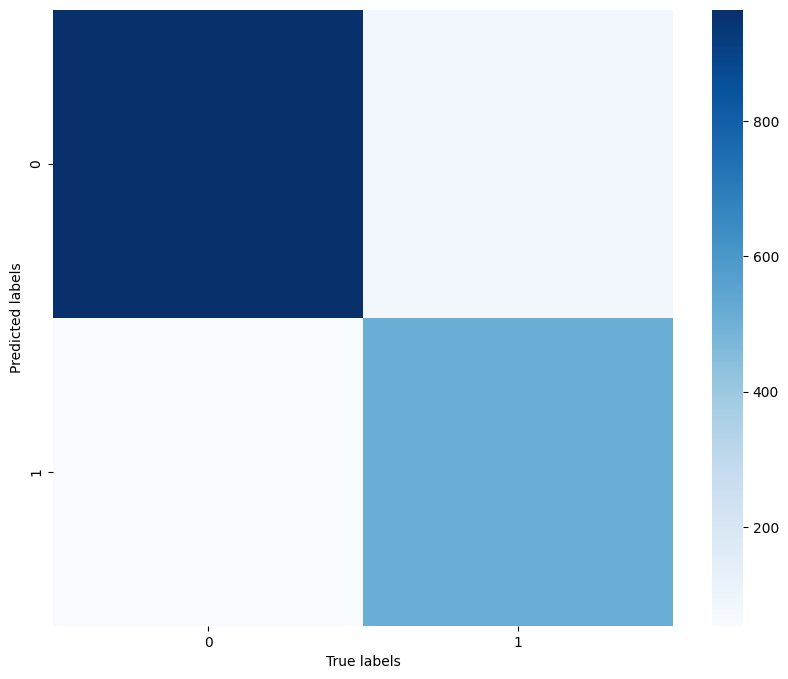

In [ ]:
#model_saved = tfk.models.load_model('EfficientNet_Fine_Tuning_6')
predictions = model.predict(X_val*255, verbose=0)

# test_accuracy = model_saved.evaluate(X_val,y_val,verbose=0)[-1]
# print('Validation set accuracy %.4f' % test_accuracy)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

